In [3]:
#https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import numpy as np
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
from datetime import date, timedelta
import win32com.client as win32
import teradatasql


In [54]:
#TR
# pass  
user="vitaly.flerin"
password="4GyyERMq!"
query = '''select trunc(create_date, 'rm') as create_date, avg(nps) as nps from uat_ca.v3_nps_bu where point_name in ('Мобильный интернет') and Eralash = 0 and region  not in ('Биробиджан', 'Хабаровск') group by 1;'''
with teradatasql.connect(host="td2800.corp.tele2.ru", user=user, password=password,logmech="ldap", tmode="TERA" ) as connect:
    df_tr = pd.read_sql(query, connect)
df_tr.head()

c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,create_date,nps
0,2020-07-01,0.107243
1,2020-10-01,0.165000
2,2021-11-01,0.234668
3,2019-02-01,0.303000
4,2019-09-01,0.227413


In [ ]:
df_tr['create_date'] = pd.to_datetime(df_tr['create_date'])
df_tr = df_tr[df_tr['create_date']>'2019-12-01']
df_tr['Region'] = 'TR'
df_tr = df_tr.sort_values(by = ['create_date'], ascending=True)
df_tr.reset_index(drop= True , inplace= True )
df_tr

<AxesSubplot:xlabel='nps', ylabel='Region'>

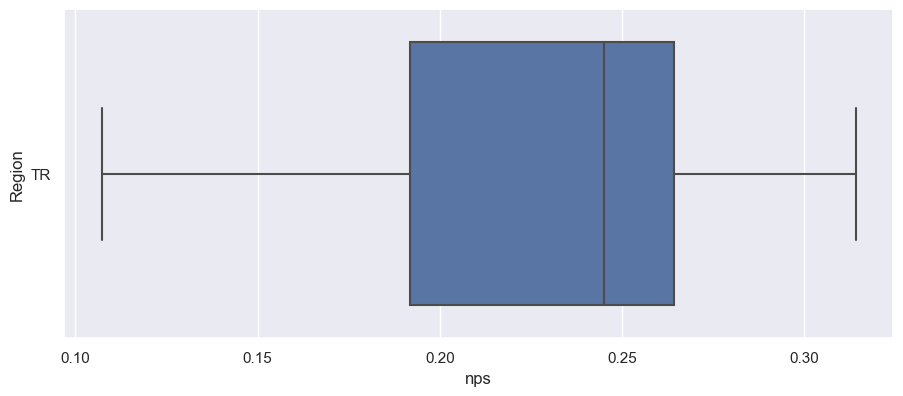

In [84]:
sns.set(rc={'figure.figsize':(10.7,4.27)})
sns.boxplot(data=df_tr, x="nps", y="Region")

In [81]:
#x = df.query('Region == "Белгород"')
def reg_punc(x, region):
    data = x['nps'].values.reshape(1, -1)
    # operate smoothing
    smoother = LowessSmoother(smooth_fraction=0.3, iterations=2)
    smoother.smooth(data)
    # generate intervals
    low, up = smoother.get_intervals('prediction_interval')
    points = smoother.data[0]
    up_points = up[0]
    low_points = low[0]
    t = x.index[0]
    
    for i in range(len(points)-1, 0, -1):
        current_point = points[i]
        current_up = up_points[i]
        current_low = low_points[i]
        if current_point > current_up or current_point < current_low:
            #tm = index(x.iloc[[i]])
            x.loc[t+i,'result'] = current_point
    return x

In [ ]:
total_df_ = pd.DataFrame()
for region in df_tr['Region'].unique().tolist():
    #print(region)
    tmp_df = df_tr[df_tr['Region'] == region]
    #tmp_df.drop('Region', axis= 1 , inplace= True )
    #tmp_df.head()
    region_forecast_df = reg_punc(tmp_df, region)
    total_df_ = pd.concat([total_df_, region_forecast_df])

df_roll = pd.DataFrame()
for reg in total_df_['Region'].unique().tolist():
    tmp = total_df_[total_df_['Region'] == reg]
    tmp['nps_roll'] = tmp['nps']. rolling (4).mean()
    #tmp_df.drop('Region', axis= 1 , inplace= True )
    #tmp_df.head()
    df_roll = pd.concat([df_roll, tmp])
    
df_roll['fin'] = np.where(df_roll['nps']==df_roll['result'], df_roll['nps_roll'], df_roll['nps'])
df_roll['fin'] = df_roll['fin'].fillna(df_roll['nps'])
df_roll
#df_roll['fin'].notnull().sum()

In [83]:
df_roll.to_excel('Res_1_сглаживание рядов_TR.xlsx')

In [85]:
#Reg 
user="vitaly.flerin"
password="4GyyERMq!!"
query = '''select trunc(create_date, 'rm') as create_date, region, avg(nps) as nps from uat_ca.v3_nps_bu where point_name in ('Мобильный интернет') and Eralash = 0 and region  not in ('Биробиджан', 'Хабаровск') group by 1, 2;'''
with teradatasql.connect(host="td2800.corp.tele2.ru", user=user, password=password,logmech="ldap", tmode="TERA" ) as connect:
    df_reg = pd.read_sql(query, connect)
df_reg.head()

c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,create_date,Region,nps
0,2021-03-01,Тамбов,0.331476
1,2021-06-01,Новосибирск,0.224796
2,2019-01-01,Ижевск,0.080153
3,2022-04-01,Владимир,0.272727
4,2022-03-01,Томск,0.229607


In [89]:
df_reg['create_date'] = pd.to_datetime(df_reg['create_date'])

df_reg = df_reg[df_reg['create_date']>'2019-12-01']

df_reg = df_reg.sort_values(by = ['Region', 'create_date'], ascending=True)
df_reg.reset_index(drop= True , inplace= True )
df_reg

,create_date,Region,nps
0,2020-01-01,Архангельск,0.213656
1,2020-02-01,Архангельск,0.165085
2,2020-03-01,Архангельск,0.202864
3,2020-04-01,Архангельск,0.272124
4,2020-05-01,Архангельск,0.073345
...,...,...,...
2441,2022-12-01,Ярославль,0.445977
2442,2023-01-01,Ярославль,0.307420
2443,2023-02-01,Ярославль,0.399449
2444,2023-03-01,Ярославль,0.423228


<AxesSubplot:xlabel='nps', ylabel='Region'>

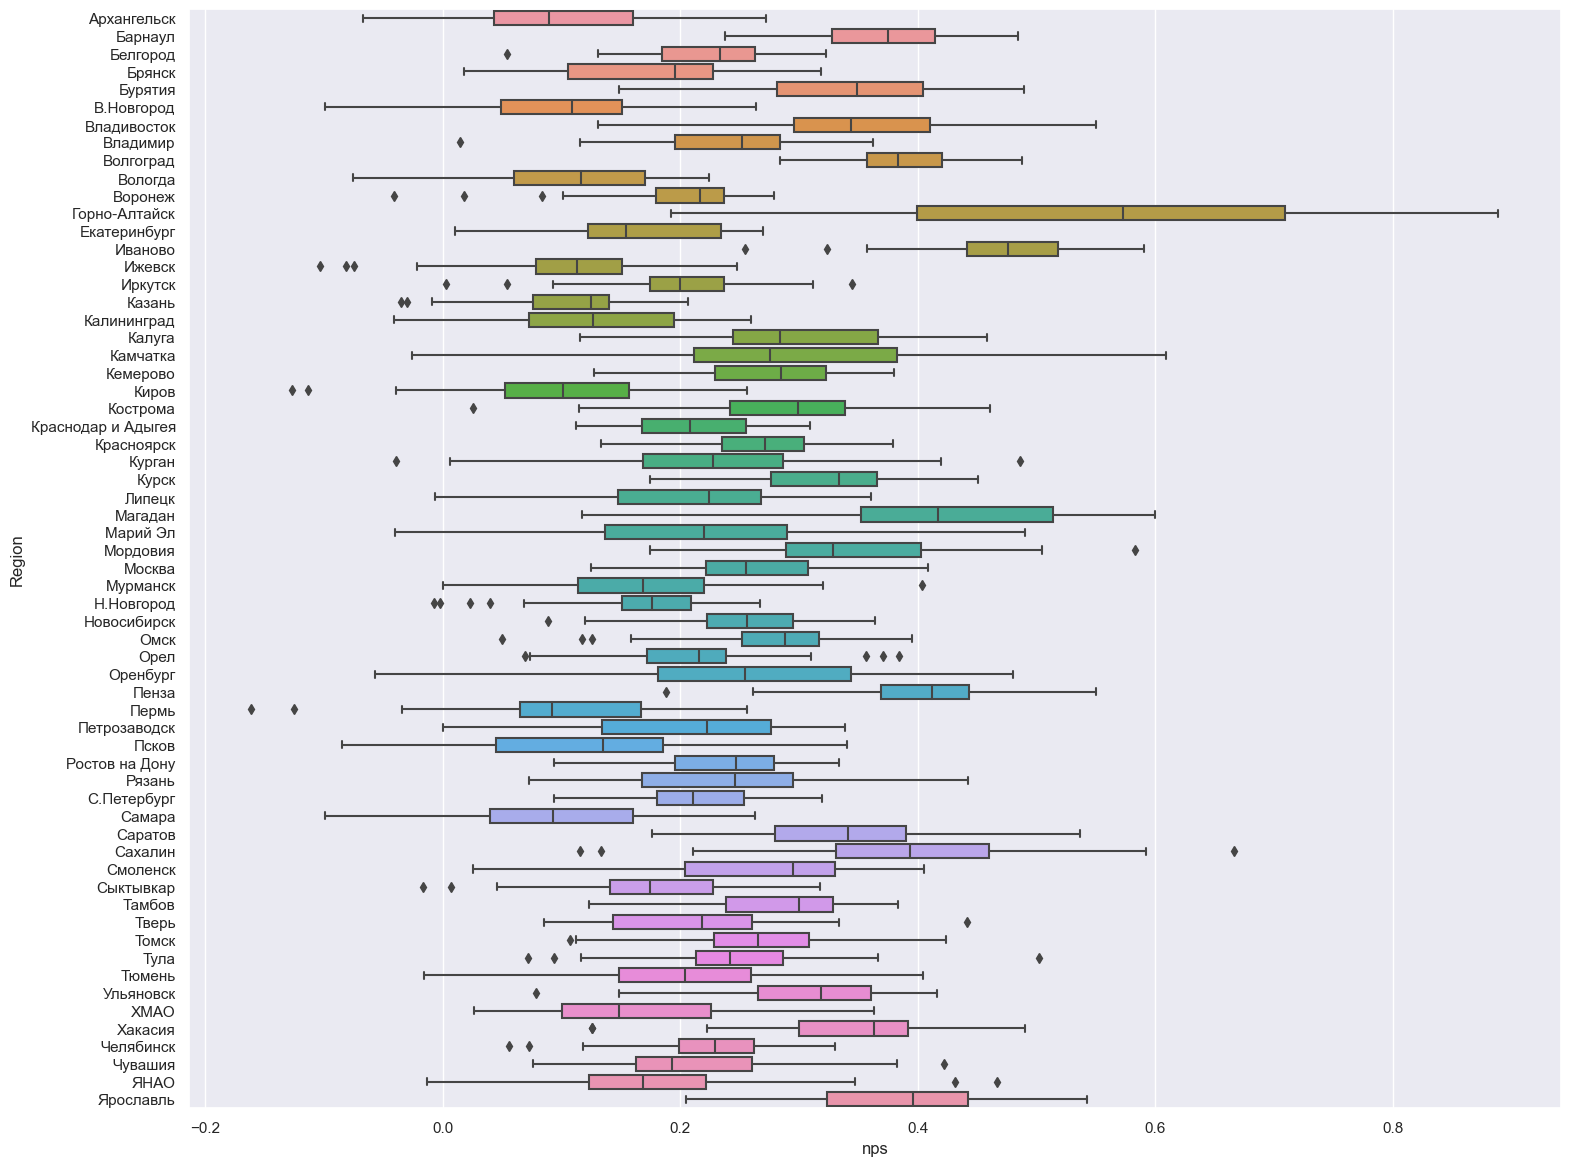

In [91]:
sns.set(rc={'figure.figsize':(17.7,14.27)})
sns.boxplot(data=df_reg, x="nps", y="Region")

In [92]:
#x = df.query('Region == "Белгород"')
def reg_punc(x, region):
    data = x['nps'].values.reshape(1, -1)
    # operate smoothing
    smoother = LowessSmoother(smooth_fraction=0.3, iterations=2)
    smoother.smooth(data)
    # generate intervals
    low, up = smoother.get_intervals('prediction_interval')
    points = smoother.data[0]
    up_points = up[0]
    low_points = low[0]
    t = x.index[0]
    
    for i in range(len(points)-1, 0, -1):
        current_point = points[i]
        current_up = up_points[i]
        current_low = low_points[i]
        if current_point > current_up or current_point < current_low:
            #tm = index(x.iloc[[i]])
            x.loc[t+i,'result'] = current_point
    return x

In [93]:
total_df_ = pd.DataFrame()
for region in df_reg['Region'].unique().tolist():
    #print(region)
    tmp_df = df_reg[df_reg['Region'] == region]
    #tmp_df.drop('Region', axis= 1 , inplace= True )
    #tmp_df.head()
    region_forecast_df = reg_punc(tmp_df, region)
    total_df_ = pd.concat([total_df_, region_forecast_df])

df_roll = pd.DataFrame()
for reg in total_df_['Region'].unique().tolist():
    tmp = total_df_[total_df_['Region'] == reg]
    tmp['nps_roll'] = tmp['nps']. rolling (4).mean()
    #tmp_df.drop('Region', axis= 1 , inplace= True )
    #tmp_df.head()
    df_roll = pd.concat([df_roll, tmp])
    
df_roll['fin'] = np.where(df_roll['nps']==df_roll['result'], df_roll['nps_roll'], df_roll['nps'])
df_roll['fin'] = df_roll['fin'].fillna(df_roll['nps'])
df_roll
#df_roll['fin'].notnull().sum()

C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_7232\2412456207.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.loc[t+i,'result'] = current_point
C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_7232\2412456207.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.loc[t+i,'result'] = current_point
C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_7232\2412456207.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,create_date,Region,nps,result,nps_roll,fin
0,2020-01-01,Архангельск,0.213656,NaN,NaN,0.213656
1,2020-02-01,Архангельск,0.165085,NaN,NaN,0.165085
2,2020-03-01,Архангельск,0.202864,NaN,NaN,0.202864
3,2020-04-01,Архангельск,0.272124,0.272124,0.213432,0.213432
4,2020-05-01,Архангельск,0.073345,NaN,0.178355,0.073345
...,...,...,...,...,...,...
2441,2022-12-01,Ярославль,0.445977,NaN,0.387050,0.445977
2442,2023-01-01,Ярославль,0.307420,NaN,0.386169,0.307420
2443,2023-02-01,Ярославль,0.399449,NaN,0.404373,0.399449
2444,2023-03-01,Ярославль,0.423228,NaN,0.394019,0.423228


In [94]:
df_roll.to_excel('Res_1_сглаживание рядов_Reg.xlsx')

In [62]:
# пункт два через квартили
x = df_tr
x['result'] = np.nan 
total_df = pd.DataFrame()
for region in x['Region'].unique().tolist():
    tmp_df = x[x['Region'] == region]
    #tmp_df.drop('Region', axis= 1 , inplace= True )
    #межквартильный 
    Q1 = np.percentile(tmp_df['nps'], 25,interpolation = 'midpoint')
    Q3 = np.percentile(tmp_df['nps'], 75,interpolation = 'midpoint')
    IQR = Q3 - Q1
    # Above Upper bound
    upper=Q3+1.5*IQR
    #Below Lower bound
    lower=Q1-1.5*IQR
    for i,row in tmp_df.iterrows():
        if row['nps']>=upper or row['nps']<=lower:
            tmp_df.loc[i,'result'] = tmp_df.loc[i,'nps'] 
    total_df = pd.concat([total_df, tmp_df])

In [63]:
total_df

,create_date,nps,Region,result
0,2020-01-01,0.286909,TR,NaN
1,2020-02-01,0.270087,TR,NaN
2,2020-03-01,0.271270,TR,NaN
3,2020-04-01,0.314125,TR,NaN
4,2020-05-01,0.252262,TR,NaN
5,2020-06-01,0.156621,TR,NaN
6,2020-07-01,0.107243,TR,NaN
7,2020-08-01,0.118427,TR,NaN
8,2020-09-01,0.122214,TR,NaN
9,2020-10-01,0.165000,TR,NaN


черновик

In [ ]:
'''#z - score
z = np.abs(stats.zscore(df['nps']))
threshold = 3
# Position of the outlier
print(np.where(z > 3))
#df.loc[[920]]'''

In [11]:
#межквартильный 
Q1 = np.percentile(df['nps'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['nps'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1


# Above Upper bound
upper=Q3+1.5*IQR
upper_array=np.array(df['nps']>=upper)
print('Upper Bound:',upper)
print(upper_array)
 
#Below Lower bound
lower=Q1-1.5*IQR
lower_array=np.array(df['nps']<=lower)
print('Lower Bound:',lower)
print(lower_array)


Upper Bound: 0.3615427595096435
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Lower Bound: 0.1287820565038647
[False False False False False False False False False False False False
 False False False False False False  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [12]:

data = df['nps'].values.reshape(1, -1)

# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.9, iterations=1)
smoother.smooth(data)

# generate intervals
low, up = smoother.get_intervals('prediction_interval')

points = smoother.data[0]
up_points = up[0]
low_points = low[0]

for i in range(len(points)-1, 0, -1):
    current_point = points[i]
    current_up = up_points[i]
    current_low = low_points[i]
    if current_point > current_up or current_point < current_low:
        print(f'found an outlier value: {current_point}')

found an outlier value: 0.12181550215056998
found an outlier value: 0.11785899878745885
found an outlier value: 0.10694489729377242


In [ ]:
df_roll = pd.DataFrame()
for reg in df['nps'].unique().tolist():
    print(reg)
    tmp = df[df['Region'] == reg]
    tmp['nps_roll'] = tmp['nps']. rolling (3).mean()
    #tmp_df.drop('Region', axis= 1 , inplace= True )
    #tmp_df.head()
    df_roll = pd.concat([df_roll, tmp])
df_roll

In [14]:
df['nps_rol'] = df['nps'].rolling(5).mean()
df.to_excel('TR+ROL.xlsx')